# Municipality movers and their effect on average age in Denmark

Imports and set magics:

In [1]:
# If the package geopandas isnt installed on your python enviroment, 
# you can do it using the below code:
#conda install geopandas

# it can take a couple of minutes....

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

# Read and clean data

I import a geojson file that contains data to draw a map of Danish municipalities.

In [3]:
#import json
import geopandas as gpd
mun_data = gpd.read_file('kommuner.geojson')
print(mun_data.head())


  KOMKODE     KOMNAVN                                           geometry
0    0766   Hedensted  POLYGON Z ((9.44919 55.86046 -999.00000, 9.460...
1    0766   Hedensted  POLYGON Z ((10.06198 55.83301 -999.00000, 10.0...
2    0561     Esbjerg  POLYGON Z ((8.59656 55.53506 -999.00000, 8.601...
3    0849  Jammerbugt  POLYGON Z ((9.78314 57.07319 -999.00000, 9.781...
4    0849  Jammerbugt  POLYGON Z ((9.19738 57.13868 -999.00000, 9.207...


Using the DST API i acces two datasets, <br>
GALDER: containing the average age in municipalities.<br>
FLY66:  containing the amount of movers to and from each municipality and their moving destination.

In [73]:
import pydst
dst = pydst.Dst(lang='en')

# GALDER
galder = dst.get_data(table_id = 'GALDER', variables={'KOMK':['*'], 'KØN':['*'], 'TID':['*']})
#galder.head()

In [ ]:
# FLY66 flytninger mellem kommuner
fly = dst.get_data(table_id = 'FLY66', variables={'TILKOMMUNE':['*'], 'FRAKOMMUNE':['*'], 'ALDER':['*'], 'KØN':['*'], 'TID':['*']})
#fly.head(5)

Clean up of the moving data.

In [5]:
# renameing the municipality variables
fly['TILKOMMUNE'] = fly['TILKOMMUNE'].str.replace(r'To ', '')
fly['FRAKOMMUNE'] = fly['FRAKOMMUNE'].str.replace(r'From ', '')

# I find the sum of people moving for every municipality pair and year.
fly_sum = fly.groupby(['TILKOMMUNE','FRAKOMMUNE'], as_index=False)['INDHOLD'].sum()

# the capital name is wrong, has to be changed
fly_sum['TILKOMMUNE'] = fly_sum['TILKOMMUNE'].replace(['Copenhagen'], 'København')
fly_sum['FRAKOMMUNE'] = fly_sum['FRAKOMMUNE'].replace(['Copenhagen'], 'København')

# the name of høje taastrup is wrong
fly_sum['TILKOMMUNE'] = fly_sum['TILKOMMUNE'].replace(['Høje-Taastrup'], 'Høje Taastrup')
fly_sum['FRAKOMMUNE'] = fly_sum['FRAKOMMUNE'].replace(['Høje-Taastrup'], 'Høje Taastrup')

# med tid
# fly_sum = fly.groupby(['TILKOMMUNE','FRAKOMMUNE','TID'], as_index=False)['INDHOLD'].sum()

fly_sum.head(5)


,TILKOMMUNE,FRAKOMMUNE,INDHOLD
0,Aabenraa,Aalborg,549
1,Aabenraa,Aarhus,2327
2,Aabenraa,Albertslund,55
3,Aabenraa,Allerød,24
4,Aabenraa,Assens,243


Data clean up of the average age dataset. 

In [74]:
# Excluding non municipality observations
I  = galder.KOMK.str.contains('Region')
I |= galder.KOMK.str.contains('All')
galder.loc[I, :]
galder = galder.loc[I == False] # keep everything else

# excluding the seperat rows for men and women, only keeping the total.
J = galder.KØN.str.contains('Total')
galder.loc[J, :]
galder = galder.loc[J == True] # keep everything else

# I will be looking at the 2020 values
galder = galder.loc[galder['TID'] == 2020]

# change some row names for consistency with the other data sets
galder['KOMK'] = galder['KOMK'].replace(['Copenhagen'], 'København')
galder['KOMK'] = galder['KOMK'].replace(['Høje-Taastrup'], 'Høje Taastrup')

# wont need the KØN column once ive restricted the data set to only contain the total.
galder.drop(columns=['KØN'], inplace=True)

galder.head(5)

,KOMK,TID,INDHOLD
2571,København,2020,36.1
2574,Frederiksberg,2020,40.0
2577,Ballerup,2020,42.3
2580,Brøndby,2020,41.7
2583,Dragør,2020,44.4


In [75]:
# saves copys of the data as excel files to the folder.
fly_sum.to_excel("fly_summeret.xlsx")
mun_data.to_excel('geopandas_mun_names.xlsx')
galder.to_excel('galder.xlsx')

# The relationship between moving and average age

I Calculate the ratio of people moving into and people moving away from each municipality.

In [76]:
#Crate two seperate datasets containing the sum of in-movers and out-movers in the municipality.
tilfly = fly_sum.groupby(['TILKOMMUNE'], as_index=False)['INDHOLD'].sum()
frafly = fly_sum.groupby(['FRAKOMMUNE'], as_index=False)['INDHOLD'].sum()

# The variables are renamed.
tilfly.rename(columns={'INDHOLD':'TILFLYT'},inplace=True)
frafly.rename(columns={'INDHOLD':'FRAFLYT'},inplace=True)

# ... and the datasets merged
fly_ratio = pd.merge(tilfly, frafly, 
                   left_on=['TILKOMMUNE'], right_on=['FRAKOMMUNE'],
                   how='inner')
 
# The ratio of in movers over out movers is calculated
fly_ratio['FLYTRATIO'] = fly_ratio['TILFLYT'] / fly_ratio['FRAFLYT']
fly_ratio['BRUTTOFLYT'] = (fly_ratio['TILFLYT'] + fly_ratio['FRAFLYT'])/1000

# The moving data is merged with the average age data. 
fly_ratio = pd.merge(fly_ratio, galder, 
                   left_on=['TILKOMMUNE'], right_on=['KOMK'],
                   how='inner')
#fly_ratio.head(1)


To showcase the relationship between the move ratio from 2006-2020 and the average age in the municipality in 2020 i create a bubble scatter plot with a trendline.

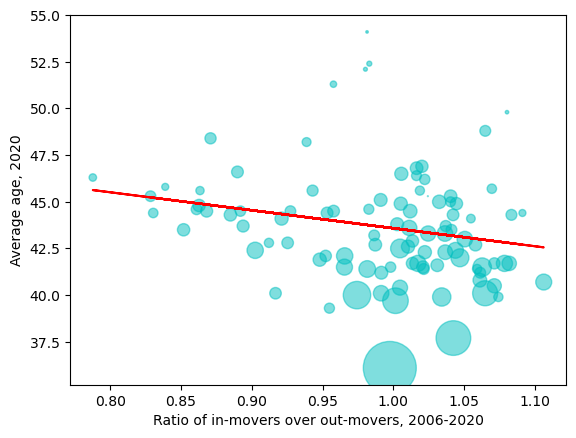

In [77]:
# A bubbel scatter plot is drawn over municipalities and their move ratio and average age
# The total amount of moving activity is used as the size of the bubbels. 
plt.scatter(fly_ratio['FLYTRATIO'], fly_ratio['INDHOLD'], s=fly_ratio['BRUTTOFLYT'] , c='c', alpha=0.5)

# a trendline is added.
z = np.polyfit(fly_ratio['FLYTRATIO'], fly_ratio['INDHOLD'], 1)
p = np.poly1d(z)
plt.plot(fly_ratio['FLYTRATIO'], p(fly_ratio['FLYTRATIO']), c='r')

# Labels and plot 
plt.xlabel("Ratio of in-movers over out-movers, 2006-2020")
plt.ylabel("Average age, 2020")
plt.show()

The correlation is calculated.

In [78]:
from scipy.stats import pearsonr

# the correlation between move ratio and average age is calculated:
corr, _ = pearsonr(fly_ratio['INDHOLD'],fly_ratio['FLYTRATIO'])

# In addition i also calculate the correlation between overall moving and 
corr_activity, _ = pearsonr(fly_ratio['BRUTTOFLYT'],fly_ratio['INDHOLD'])

covariance = cov(fly_ratio['INDHOLD'],fly_ratio['FLYTRATIO'])
print(f'The correlation between the move ratio and the average age is: {corr:.2f}')
print(f'The correlation between the overall moving activity and the average age is: {corr_activity:.2f}')


The correlation between the move ratio and the average age is: -0.23
The correlation between the overall moving activity and the average age is: -0.49


We can conclude that municipalitites with more movers on average have a higher average age. 
Does moving cause the aveage age to go up? - i think so.

We can also notice that larger bubbles tend to be low in the diagram: municipalities with alot of activity are usually younger...

# Mapping analysis

I merge the geojson data with the datasets of interest

In [79]:
# The moving data
fly_geo = pd.merge(mun_data, fly_sum, 
                   left_on=['KOMNAVN'], right_on=['FRAKOMMUNE'],
                   how='inner')

# The moving ratio and average age data
fly_ratio_geo = pd.merge(mun_data, fly_ratio, 
                   left_on=['KOMNAVN'], right_on=['TILKOMMUNE'],
                   how='inner')

Below is drawn a map where each municipality maps is colored after its averae age. <br> Allerød kommune is missing

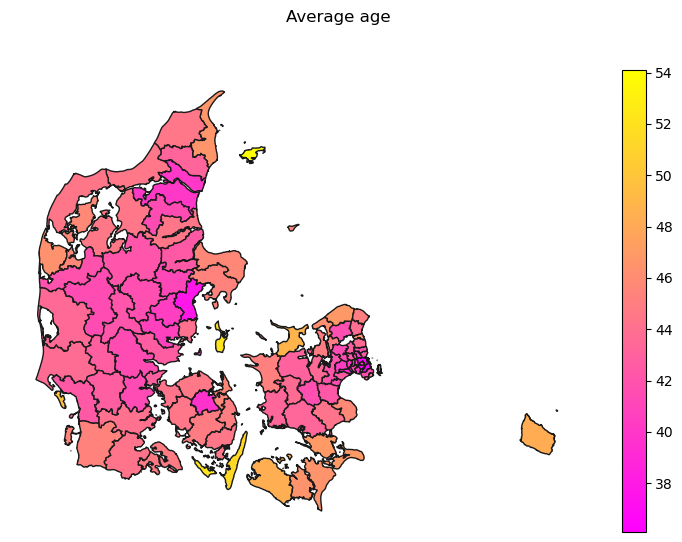

In [88]:
fig, ax = plt.subplots(1, figsize=(10,6))
fig.suptitle('Average age')
fly_ratio_geo.plot(column='INDHOLD', 
                        missing_kwds={"color": "lightgrey","edgecolor": "red","hatch": "///","label": "Missing values",}, 
                        cmap='spring', linewidth=1, ax=ax, edgecolor='0.1', 
                        legend = True)


ax.axis('off')
fig.savefig('average_age.pdf')

Next i map the destination of movers to the three municipalities containing the three largest cities in Denmark: København, Aarhus and Odense.

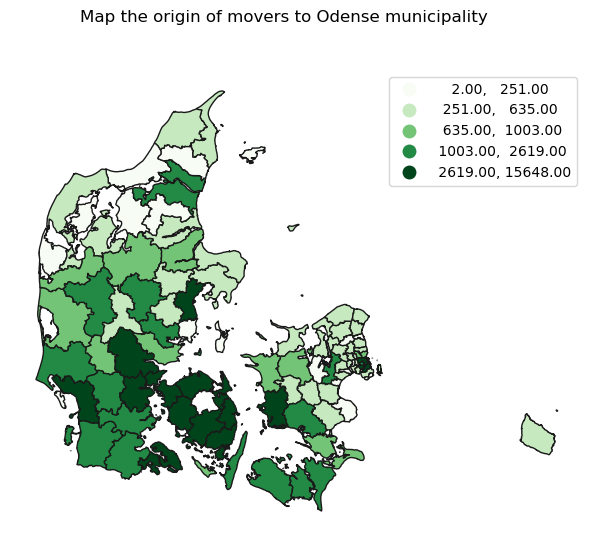

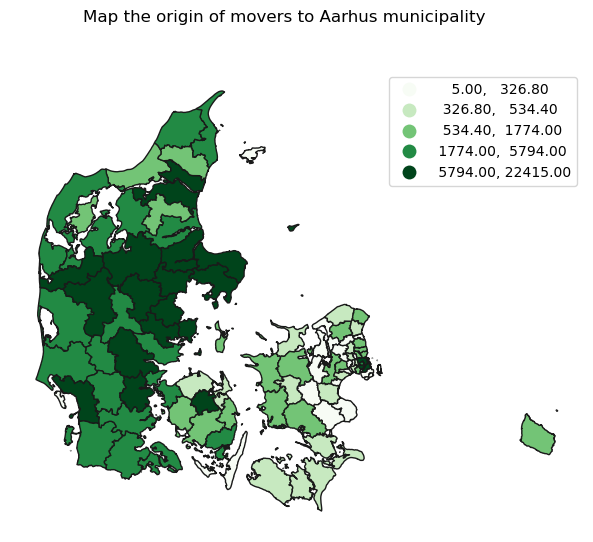

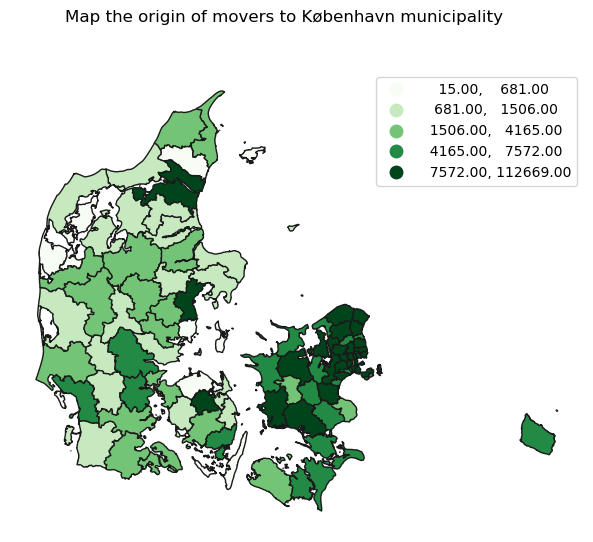

In [99]:

# Odense
fig, ax = plt.subplots(1, figsize=(10,6))
fig.suptitle('Map the origin of movers to Odense municipality')
fly_geo[fly_geo['TILKOMMUNE']=="Odense"].plot(column='INDHOLD', 
                                                     missing_kwds={"color": "lightgrey","edgecolor": "red","hatch": "///","label": "Missing values",}, 
                                                     cmap='Greens', linewidth=1, ax=ax, edgecolor='0.1', 
                                                     legend = True, scheme = 'quantiles')
ax.axis('off')
fig.savefig('Odense.pdf')


# Aarhus
fig, ax = plt.subplots(1, figsize=(10,6))
fig.suptitle('Map the origin of movers to Aarhus municipality')
fly_geo[fly_geo['TILKOMMUNE']=="Aarhus"].plot(column='INDHOLD', 
                                                     missing_kwds={"color": "lightgrey","edgecolor": "red","hatch": "///","label": "Missing values",}, 
                                                     cmap='Greens', linewidth=1, ax=ax, edgecolor='0.1', 
                                                     legend = True, scheme = 'quantiles')
ax.axis('off')
fig.savefig('Aarhus.pdf')

# København
fig, ax = plt.subplots(1, figsize=(10,6))
fig.suptitle('Map the origin of movers to København municipality')
fly_geo[fly_geo['TILKOMMUNE']=="København"].plot(column='INDHOLD', 
                                                     missing_kwds={"color": "lightgrey","edgecolor": "red","hatch": "///","label": "Missing values",}, 
                                                     cmap='Greens', linewidth=1, ax=ax, edgecolor='0.1', 
                                                     legend = True, scheme = 'quantiles')
ax.axis('off')
fig.savefig('København.pdf')


# Conclusion

In this project ive explored the relationship between moving pattern in Denmark and differences in average age between municipalities. 
<br>
<br>
I found that municipalities that more people move to, than from, tend to have a younger average age than municipalities with more movers from than to. 
<br>
<br>
We also saw that younger municipalities tend to be larger and have more moving activity in general. 
<br>
<br>
I conclude that the movement patterns in Denmark is a cause of differences in average age acroos municipalities. 